In [1]:
# eventually install EfficientNets
# or other needed packages
# using OLD efficient Net
# gaussian blur
# 22/08/2020
# 512x512

In [2]:
import pandas as pd, numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
import tensorflow.keras.backend as K

# now part of tensorflow
import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import re, math
import time

In [3]:
# to remove some warnings

# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
DEVICE = "GPU" # or "TPU"

# TFRecords file for training (not Kaggle location !)
BASE_DIR = '/home/ubuntu/kaggle/diabetic'

TFREC_DIR = os.path.join(BASE_DIR, "tfrec")

# number of folds for CV
FOLDS = 5

# WHICH IMAGE SIZES TO LOAD 
# CHOOSE 128, 192, 256, 384, 512, 768 

IMG_SIZES = 512

IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]


# tune it, dependes on Image, size, TPU or GPU
BATCH_SIZE = 12

EPOCHS = 25

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 4

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = 1/FOLDS

NUM_CLASSES = 5

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  2
Using strategy for multiple GPU
REPLICAS: 2


In [6]:
# adding some data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  # introduced in TF 2.3
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])

In [7]:
# not using metadata (only image, for now)
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        'patient_id' : tf.io.FixedLenFeature([], tf.int64), 
        'side' : tf.io.FixedLenFeature([], tf.int64),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    patient_id = example['patient_id']
    side = example['side']
    label = example['label']
    
    return image, label

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [9]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = 256, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # introdotta la data augmentation come parte del modello
    x = data_augmentation(inp)
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0) 
    
    model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
model_test = build_model(ef=4)

model_test.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, 16, 16, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [11]:
# definisce la variazione temporale del learning rate

def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.000020 * REPLICAS * batch_size/16
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 2
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    return lr_callback

In [12]:
# constant to customize output
SHOW_FILES = True
VERBOSE = 1
PLOT = 1

skf = KFold(n_splits = FOLDS, shuffle = True, random_state=42)

# for others investigations
# we store all the history
histories = []

# these will be split in folds
num_total_train_files = len(tf.io.gfile.glob(TFREC_DIR + '/train*.tfrec'))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(num_total_train_files))):
    
    tStart = time.time()
    
    # display fold info
    print('#'*60) 
    print('#### FOLD', fold+1)
    
    print('#### Image Size %i, EfficientNet B%i, batch_size %i'%
          (IMG_SIZES, EFF_NETS, BATCH_SIZE*REPLICAS))
    print('#### Epochs: %i' %(EPOCHS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    files_train = tf.io.gfile.glob([TFREC_DIR + '/train%.2i*.tfrec'%x for x in idxT])
    
    np.random.shuffle(files_train) 
    print('#'*60)
    
    files_valid = tf.io.gfile.glob([TFREC_DIR + '/train%.2i*.tfrec'%x for x in idxV])
    
    if SHOW_FILES:
        print('Number of training images', count_data_items(files_train))
        print('Number of validation images', count_data_items(files_valid))
        
    # BUILD MODEL
    if DEVICE=='TPU':
        # to avoid OOM
        tf.tpu.experimental.initialize_tpu_system(tpu)
            
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
        
    # callback to save best model for each fold
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    csv_logger = tf.keras.callbacks.CSVLogger('training_retina-%i.log'%fold)
    
    # TRAIN
    history = model.fit(
        get_training_dataset(files_train), 
        epochs=EPOCHS, 
        callbacks = [sv, get_lr_callback(BATCH_SIZE), csv_logger], 
        steps_per_epoch = count_data_items(files_train)/BATCH_SIZE//REPLICAS,
        validation_data = get_training_dataset(files_valid), 
        validation_steps = count_data_items(files_valid)/BATCH_SIZE//REPLICAS,
        verbose=VERBOSE)
    
    # save all histories
    histories.append(history)
    
    tElapsed = round(time.time() - tStart, 1)
    
    print(' ')
    print('Time (sec) elapsed for fold: ', tElapsed)
    print('...')
    print('...')

############################################################
#### FOLD 1
#### Image Size 512, EfficientNet B4, batch_size 24
#### Epochs: 25
############################################################
Number of training images 27126
Number of validation images 8000

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/25
1130/1130 [==============================] - ETA: 0s - loss: 1.0258 - accuracy: 0.6926
Epoch 00001: val_loss improved from inf to 0.83664, saving model to fold-0.h5
1130/1130 [==============================] - 666s 589ms/step - loss: 1.0258 - accuracy: 0.6926 - val_loss: 0.8366 - val_accuracy: 0.7335

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0000000000000003e-05.
Epoch 2/25
1130/1130 [==============================] - ETA: 0s - loss: 0.7790 - accuracy: 0.7442
Epoch 00002: val_loss improved from 0.83664 to 0.69599, saving model to fold-0.h5
1130/1130 [==============================] - 662s 586ms/step - loss: 0.7790 - accurac


Epoch 00022: LearningRateScheduler reducing learning rate to 2.2754334882201614e-06.
Epoch 22/25
1130/1130 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.8562
Epoch 00022: val_loss did not improve from 0.44970
1130/1130 [==============================] - 660s 584ms/step - loss: 0.4388 - accuracy: 0.8562 - val_loss: 0.4583 - val_accuracy: 0.8483

Epoch 00023: LearningRateScheduler reducing learning rate to 2.020346790576129e-06.
Epoch 23/25
1130/1130 [==============================] - ETA: 0s - loss: 0.4239 - accuracy: 0.8591
Epoch 00023: val_loss did not improve from 0.44970
1130/1130 [==============================] - 662s 586ms/step - loss: 0.4239 - accuracy: 0.8591 - val_loss: 0.4683 - val_accuracy: 0.8486

Epoch 00024: LearningRateScheduler reducing learning rate to 1.816277432460903e-06.
Epoch 24/25
1130/1130 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8585
Epoch 00024: val_loss did not improve from 0.44970
1130/1130 [=========

1130/1130 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.8577
Epoch 00017: val_loss did not improve from 0.44009
1130/1130 [==============================] - 655s 580ms/step - loss: 0.4327 - accuracy: 0.8577 - val_loss: 0.4544 - val_accuracy: 0.8529

Epoch 00018: LearningRateScheduler reducing learning rate to 4.113851289600002e-06.
Epoch 18/25
1130/1130 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8544
Epoch 00018: val_loss improved from 0.44009 to 0.43341, saving model to fold-1.h5
1130/1130 [==============================] - 658s 583ms/step - loss: 0.4453 - accuracy: 0.8544 - val_loss: 0.4334 - val_accuracy: 0.8589

Epoch 00019: LearningRateScheduler reducing learning rate to 3.491081031680002e-06.
Epoch 19/25
1130/1130 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8537
Epoch 00019: val_loss did not improve from 0.43341
1130/1130 [==============================] - 657s 582ms/step - loss: 0.4384 - accuracy:


Epoch 00013: LearningRateScheduler reducing learning rate to 1.0502720000000003e-05.
Epoch 13/25
1166/1166 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8552
Epoch 00013: val_loss improved from 0.47354 to 0.46756, saving model to fold-2.h5
1166/1166 [==============================] - 673s 577ms/step - loss: 0.4474 - accuracy: 0.8552 - val_loss: 0.4676 - val_accuracy: 0.8514

Epoch 00014: LearningRateScheduler reducing learning rate to 8.602176000000003e-06.
Epoch 14/25
1166/1166 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8501
Epoch 00014: val_loss did not improve from 0.46756
1166/1166 [==============================] - 673s 577ms/step - loss: 0.4510 - accuracy: 0.8501 - val_loss: 0.4721 - val_accuracy: 0.8429

Epoch 00015: LearningRateScheduler reducing learning rate to 7.081740800000003e-06.
Epoch 15/25
1166/1166 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8582
Epoch 00015: val_loss did not improve fr

1213/1213 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.8358
Epoch 00008: val_loss did not improve from 0.49964
1213/1213 [==============================] - 692s 570ms/step - loss: 0.5071 - accuracy: 0.8358 - val_loss: 0.5036 - val_accuracy: 0.8313

Epoch 00009: LearningRateScheduler reducing learning rate to 2.4200000000000005e-05.
Epoch 9/25
1213/1213 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.8394
Epoch 00009: val_loss improved from 0.49964 to 0.47733, saving model to fold-3.h5
1213/1213 [==============================] - 693s 571ms/step - loss: 0.4895 - accuracy: 0.8394 - val_loss: 0.4773 - val_accuracy: 0.8510

Epoch 00010: LearningRateScheduler reducing learning rate to 1.9560000000000006e-05.
Epoch 10/25
1213/1213 [==============================] - ETA: 0s - loss: 0.4703 - accuracy: 0.8460
Epoch 00010: val_loss improved from 0.47733 to 0.47192, saving model to fold-3.h5
1213/1213 [==============================] - 693s 571ms


Epoch 00004: LearningRateScheduler reducing learning rate to 2.0000000000000005e-05.
Epoch 4/25
1213/1213 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.7969
Epoch 00004: val_loss improved from 0.58401 to 0.53952, saving model to fold-4.h5
1213/1213 [==============================] - 694s 572ms/step - loss: 0.6260 - accuracy: 0.7969 - val_loss: 0.5395 - val_accuracy: 0.8290

Epoch 00005: LearningRateScheduler reducing learning rate to 2.5000000000000005e-05.
Epoch 5/25
1213/1213 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.8129
Epoch 00005: val_loss improved from 0.53952 to 0.48572, saving model to fold-4.h5
1213/1213 [==============================] - 693s 571ms/step - loss: 0.5762 - accuracy: 0.8129 - val_loss: 0.4857 - val_accuracy: 0.8420

Epoch 00006: LearningRateScheduler reducing learning rate to 3.0000000000000004e-05.
Epoch 6/25
1213/1213 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.8195
Epoch 0000

1213/1213 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8600
Epoch 00025: val_loss did not improve from 0.43344
1213/1213 [==============================] - 695s 573ms/step - loss: 0.4244 - accuracy: 0.8600 - val_loss: 0.4378 - val_accuracy: 0.8520
 
Time (sec) elapsed for fold:  17432.5
...
...


In [13]:
def plot_loss(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.title('Loss fold n. ' + str(fold + 1) )
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

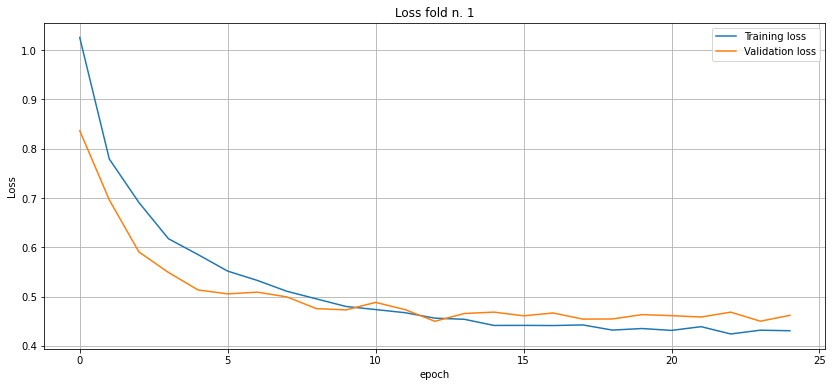

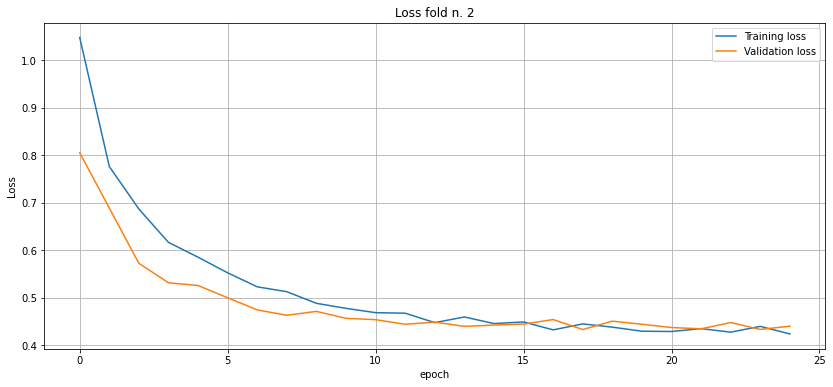

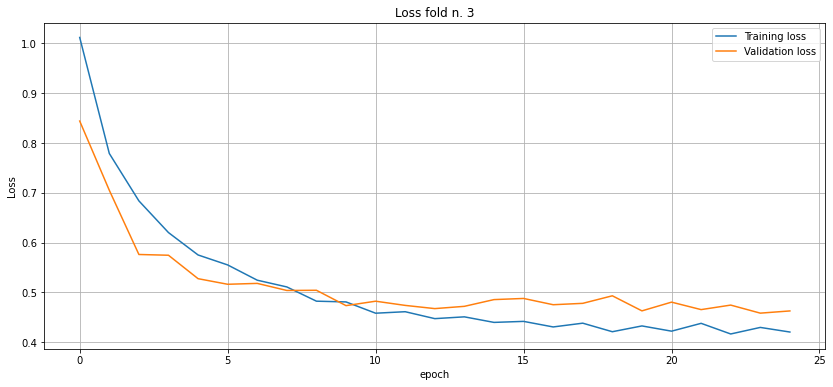

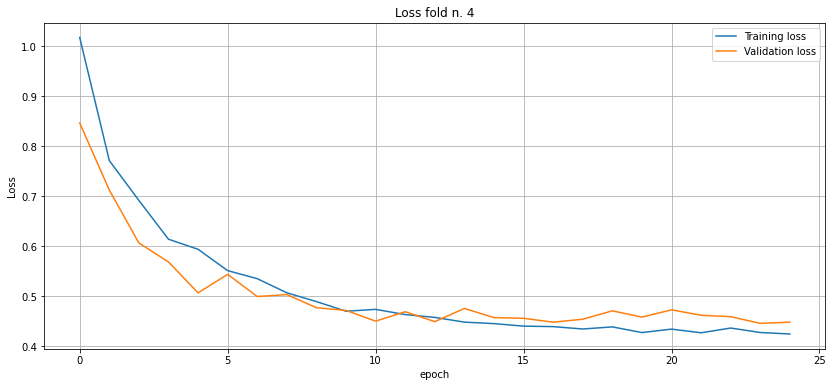

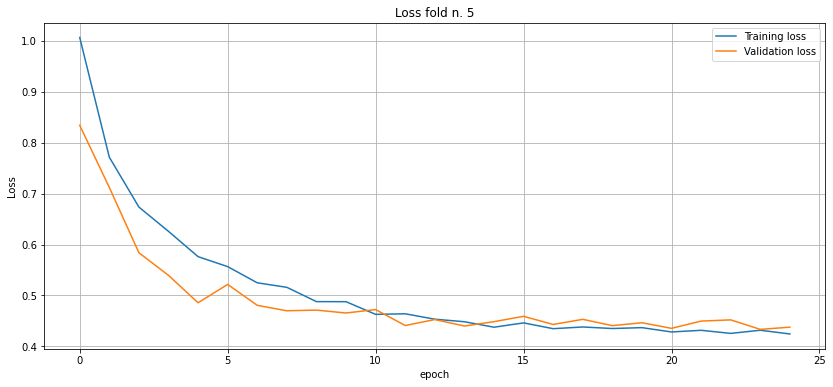

In [14]:
for fold in range(FOLDS):
    plot_loss(histories[fold])

In [15]:
def plot_acc(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['accuracy'], label='Training accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy fold n. ' + str(fold + 1) )
    plt.legend(loc='lower right')
    plt.ylabel('Acc')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

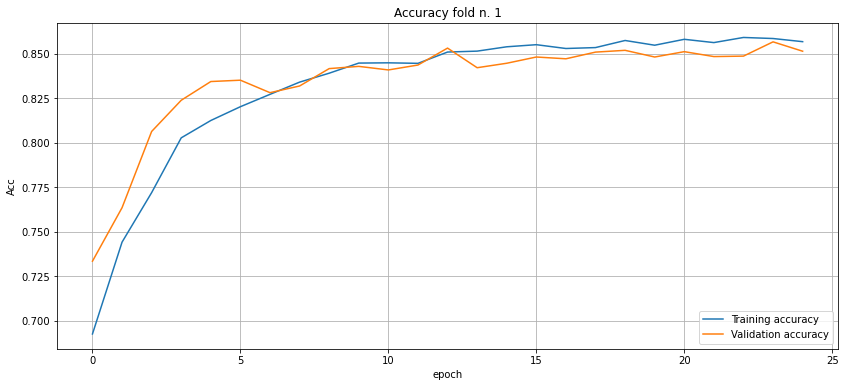

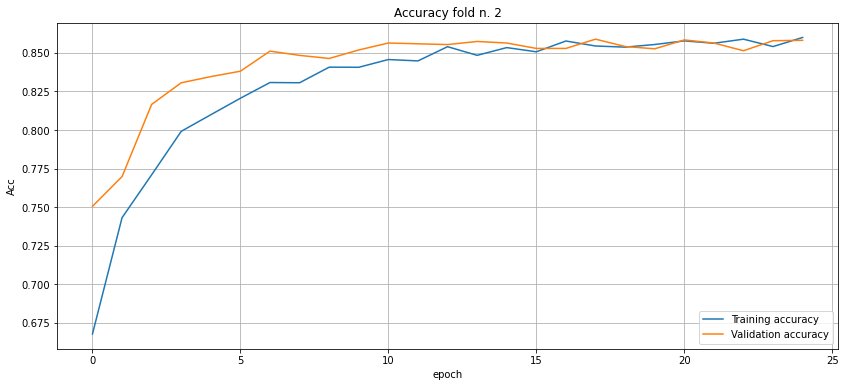

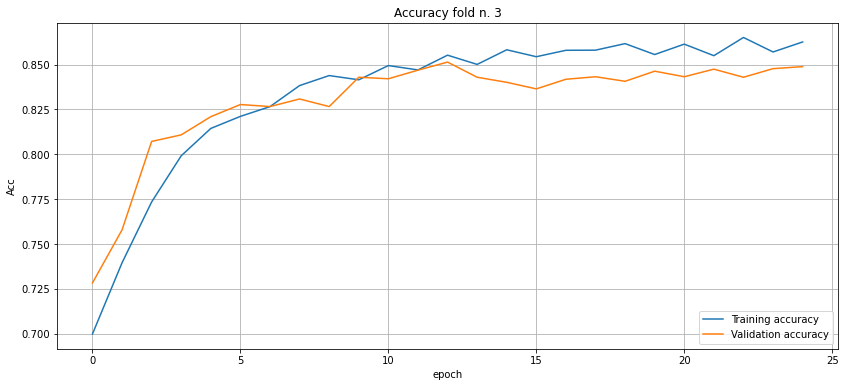

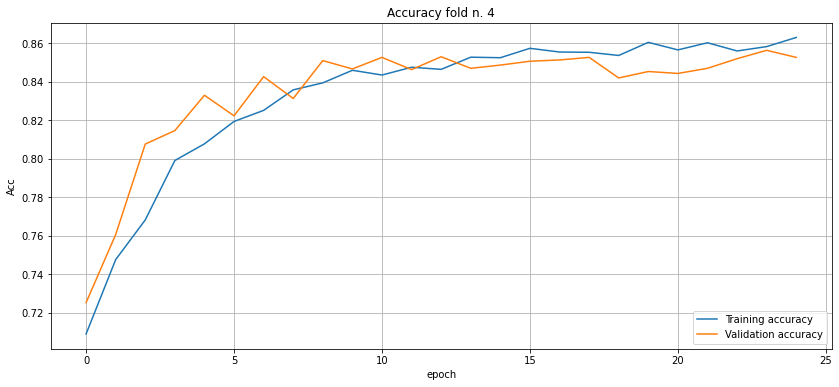

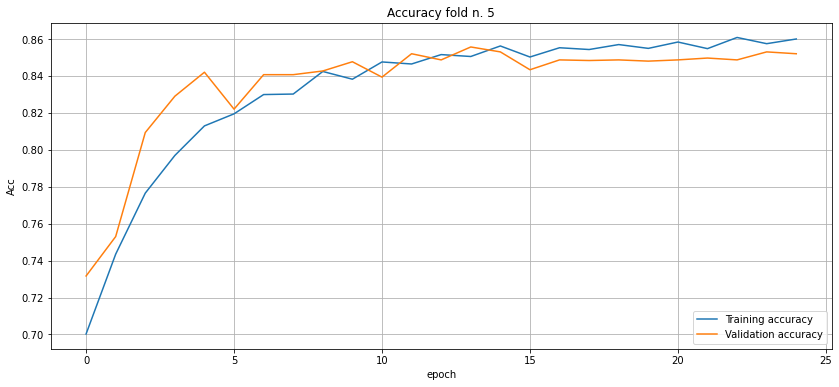

In [16]:
for fold in range(FOLDS):
    plot_acc(histories[fold])

In [17]:
# calcolo su train set l'accuratezza dei 5 modelli (folds)

files_test = tf.io.gfile.glob(TFREC_DIR + '/train*.tfrec')

num_total_test_files = len(tf.io.gfile.glob(TFREC_DIR + '/train*.tfrec'))

wi = [1/FOLDS]*FOLDS

avg_acc = 0

for fold in range(FOLDS):
    model.load_weights('fold-%i.h5'%fold)
    
    test_loss, test_acc = model.evaluate(get_training_dataset(files_test), verbose = 0, batch_size = 4*BATCH_SIZE,
                                        steps = num_total_test_files/4*BATCH_SIZE//REPLICAS)

    print('Train accuracy fold n.', fold+1, ': ', round(test_acc, 4))

    avg_acc += test_acc * wi[fold]

print('Average accuracy: ', round(avg_acc,4))

Train accuracy fold n. 1 :  0.8364
Train accuracy fold n. 2 :  0.8364
Train accuracy fold n. 3 :  0.8889
Train accuracy fold n. 4 :  0.8549
Train accuracy fold n. 5 :  0.8642
Average accuracy:  0.8562


In [ ]:
# 23/08/2020: passando da 256x256 cin circle crop e gb a 512x512 l'accuratezza media (cv=5) sul rain set è passata 
# ds 0.831 a 0.856, un migliormento significativo

# now predictions on test set

In [ ]:
# ok con il center crop + gaussian blur sono passato al 0.83 di accuracy